In [ ]:
# ARIMA MODEL
# Fit an ARIMA model.

# There are three hyperparameters we need to get values for when fitting an ARIMA model.
# Determine a value of  using the Augmented Dickey-Fuller test.

# Then, determine values of  and  through GridSearching.

# An  model is specified by:
# -how many differences  we need to calculate in order to achieve stationarity.
# -how many lags  we regress  on.
# -how many errors  we regress  on.


# Depending on our values of , , and , we might refer to these models by slightly different names.
# If  and , an AR(p) model is specified by how many lags  we regress  on.
# If  and , an MA(q) model is specified by how many errors  we regress  on.
# If , an ARMA(p, q) model is specified by how many lags  and how many errors  we regress  on.

In [1]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.pipeline import Pipeline
import pymssql
import pandas as pd
import datetime as dt
import plotly.express as px

In [2]:

database = "arctic_analysts_capstone"
user = "arctic_analysts"
password  = "ThisPassw0rd!"
server = "gen10-data-fundamentals-22-02-sql-server.database.windows.net"

def sql_query(query):
    conn = pymssql.connect(server, user, password, database)
    cursor = conn.cursor()
    queried_data = pd.read_sql(query, conn)
    return queried_data

In [3]:
def run_queries():
    tables = ["year", "month", "county", "median_income", "main_table"]

    query = f"SELECT * FROM {tables[0]}"
    year_df = sql_query(query)

    query = f"SELECT * FROM {tables[1]}"
    month_df = sql_query(query)

    query = f"SELECT * FROM {tables[2]}"
    county_df = sql_query(query)

    query = f"SELECT * FROM {tables[3]}"
    median_income_df = sql_query(query)

    query = f"SELECT * FROM {tables[4]}"
    main_table = sql_query(query)

    all_df = [year_df, month_df, county_df, median_income_df, main_table]
    return all_df

In [4]:
def join_tables(all_df):
    year_df = all_df[0]
    month_df = all_df[1]
    county_df = all_df[2]
    median_income_df = all_df[3]
    main_table = all_df[4]

    master_table = pd.merge(
        main_table, year_df, left_on="YearID", right_on="YearID", how="outer"
    )
    print(master_table.shape[0])
    # Now has 5607 rows

    master_table = pd.merge(
        master_table, month_df, left_on="MonthID", right_on="MonthID", how="outer"
    )
    # Now has 5607 rows
    print(master_table.shape[0])

    master_table = pd.merge(
        master_table, county_df, left_on="FIPS", right_on="FIPS", how="outer"
    )
    # Now has 5607 rows
    print(master_table.shape[0])

    master_table = pd.merge(
        master_table,
        median_income_df,
        left_on=["FIPS", "YearID"],
        right_on=["FIPS", "YearID"],
        how="outer",
    )
    # Now has 20727 rows
    print(master_table.shape[0])

    master_table.loc[(master_table.MedianIncome < 0), "MedianIncome"] = None
    return master_table

In [5]:
all_df = run_queries()

In [6]:
master_table = join_tables(all_df)

5607
5607
5607
20727


In [7]:
master_table

,FIPS,YearID,MonthID,NewUnits,NewBuildings,MedianHousePrice,AverageRate,AveragePoints,Year,Month,County,AgeGroup,MedianIncome
0,34001,1,1,66,66,136880.0,8.21,1.0,2000,Jan,Atlantic County,NaN,NaN
1,34001,1,2,110,110,137379.0,8.33,1.0,2000,Feb,Atlantic County,NaN,NaN
2,34001,1,3,98,87,137794.0,8.24,1.0,2000,Mar,Atlantic County,NaN,NaN
3,34001,1,4,90,90,138680.0,8.15,1.0,2000,Apr,Atlantic County,NaN,NaN
4,34001,1,5,121,121,139644.0,8.52,1.0,2000,May,Atlantic County,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20722,34041,22,11,26,14,334266.0,3.07,0.7,2021,Nov,Warren County,NaN,NaN
20723,34041,22,12,19,18,336388.0,3.10,0.6,2021,Dec,Warren County,NaN,NaN
20724,34041,23,1,13,12,338845.0,3.45,0.7,2022,Jan,Warren County,NaN,NaN
20725,34041,23,2,29,18,340046.0,3.76,0.8,2022,Feb,Warren County,NaN,NaN


In [99]:
house_price_df = master_table[['MedianHousePrice','Year', 'Month', 'MonthID','FIPS']].copy()

house_price_df = house_price_df[(house_price_df['FIPS'] == '34001')]

house_price_df.sort_values(by = ['Year', 'MonthID'], ascending = [True, True], inplace = True)

def convert_to_date(year, month):
    date = dt.datetime.strptime(f"{year}-{month}", "%Y-%b")#.date()
    #date = dt.datetime.strftime(date, "%Y-%m")
    return date

# Create a date to pass into the index for the model
house_price_df['date'] = house_price_df.apply(lambda row: convert_to_date(row.Year, row.Month), axis = 1)

# Get only the relevant columns
house_price_df = house_price_df[['MedianHousePrice', 'date']]

# Set the index as the date for the squeeze to series
house_price_df.set_index('date', inplace = True)

series = house_price_df.squeeze()

# Set the index as a period array
series.index = series.index.to_period('M')

house_price_df.describe()

,MedianHousePrice
count,987.000000
mean,231404.531915
std,43097.853200
min,136880.000000
25%,202862.000000
50%,213595.000000
75%,258515.000000
max,318877.000000


In [104]:
series

date
2000-01    136880.0
2000-02    137379.0
2000-03    137794.0
2000-04    138680.0
2000-05    139644.0
             ...   
2021-11    291523.0
2021-12    294593.0
2022-01    298233.0
2022-02    303616.0
2022-03    309748.0
Freq: M, Name: MedianHousePrice, Length: 987, dtype: float64

In [105]:
from statsmodels.tsa.stattools import adfuller

In [106]:
adfuller

<function statsmodels.tsa.stattools.adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)>

In [107]:
adfuller(series)

(-1.418810051406821,
 0.573225864755095,
 21,
 965,
 {'1%': -3.4371445907959832,
  '5%': -2.864539720789528,
  '10%': -2.5683672133480093},
 14629.565538304234)

In [ ]:
# fail to reject the null because the pvalue is high

In [122]:
df

,MedianHousePrice,first_diff_mhp,second_diff_mhp
date,,,
2000-01,136880.0,NaN,NaN
2000-02,137379.0,499.0,NaN
2000-03,137794.0,415.0,-84.0
2000-04,138680.0,886.0,471.0
2000-05,139644.0,964.0,78.0
...,...,...,...
2021-11,291523.0,1427.0,-2072.0
2021-12,294593.0,3070.0,1643.0
2022-01,298233.0,3640.0,570.0


In [109]:
df.set_index('date', inplace = True)

In [111]:
df['first_diff_mhp'] = df['MedianHousePrice'].diff()

In [116]:
df['second_diff_mhp'] = df['MedianHousePrice'].diff().diff()

In [117]:
df

,MedianHousePrice,first_diff_mhp,second_diff_mhp
date,,,
2000-01,136880.0,NaN,NaN
2000-02,137379.0,499.0,NaN
2000-03,137794.0,415.0,-84.0
2000-04,138680.0,886.0,471.0
2000-05,139644.0,964.0,78.0
...,...,...,...
2021-11,291523.0,1427.0,-2072.0
2021-12,294593.0,3070.0,1643.0
2022-01,298233.0,3640.0,570.0


In [114]:
adfuller(df['first_diff_mhp'].dropna())

(-1.4375807052154124,
 0.5641328241575112,
 22,
 963,
 {'1%': -3.4371587399783072,
  '5%': -2.8645459603872903,
  '10%': -2.568370536787406},
 14613.60489046329)

In [118]:
adfuller(df['second_diff_mhp'].dropna())

(-7.224655140437271,
 2.0681176152242449e-10,
 22,
 962,
 {'1%': -3.4371658366910216,
  '5%': -2.8645490899304784,
  '10%': -2.5683722036989813},
 14598.276620493272)

In [121]:
df.index = pd.to_datetime()

period[M]

TypeError: float() argument must be a string or a number, not 'Period'

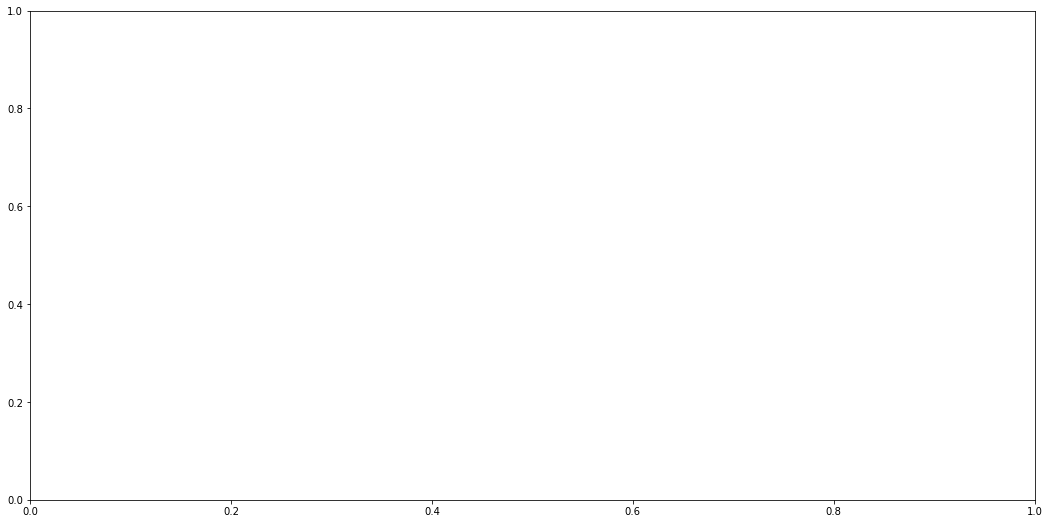

In [119]:
import matplotlib.pyplot as plt
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);
    
plot_series(df, ['second_diff_mhp'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

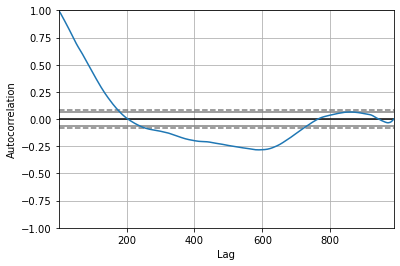

In [103]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)

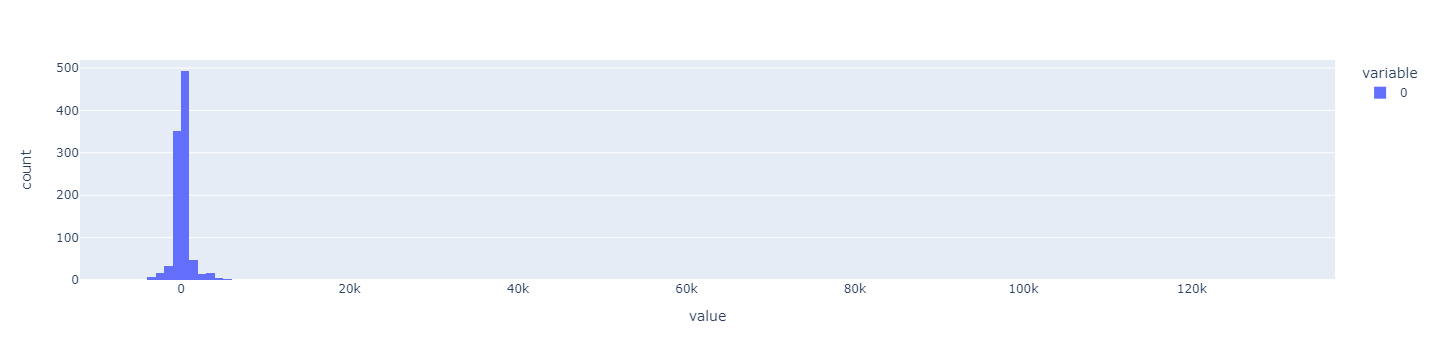

In [100]:
# Parameters
# p = number of lag observations included in the model
# d = number of times that the raw observations are differenced (degree of differencing)
# q = size of moving average window (order of moving average)

model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

#print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
#residuals.plot()

residual_data = residuals.reset_index()
residual_data.reset_index(inplace = True)

px.line(x = residual_data['index'], y = residual_data[0])

px.histogram(residual_data[0])

C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



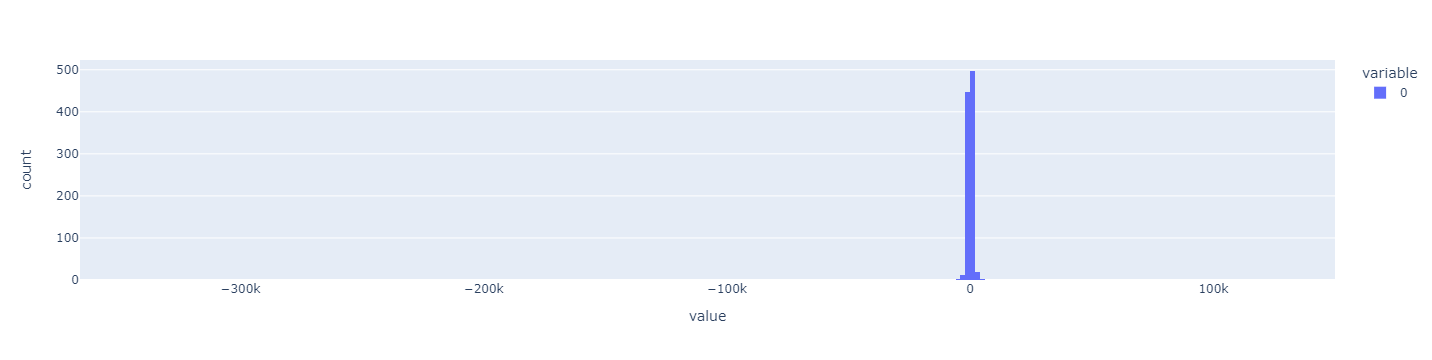

In [102]:
# Parameters
# p = number of lag observations included in the model
# d = number of times that the raw observations are differenced (degree of differencing)
# q = size of moving average window (order of moving average)

model = ARIMA(series, order=(15,5,15))
model_fit = model.fit()

#print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
#residuals.plot()

residual_data = residuals.reset_index()
residual_data.reset_index(inplace = True)

px.line(x = residual_data['index'], y = residual_data[0])

px.histogram(residual_data[0])